In [1]:
# *****************************************************
# * Import required packages and set up path for ODYM *
# *****************************************************
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.network_graph import NetworkGraph
from core.flowsolver import FlowSolver
from core.parameters import ParameterName
from core.utils import setup_current_working_directory, setup_odym_directories, create_output_directory, \
    setup_scenario_output_directories, \
    calculate_scenario_mass_balance, build_mfa_system_for_scenario, shorten_sheet_name

# NOTE: These needs to be called before importing ODYM classes
setup_current_working_directory()
setup_odym_directories()
create_output_directory(os.path.join(os.getcwd(), "output"))

In [2]:
# ******************************************************
# * Step 1: Load the data from Excel file DataProvider *
# ******************************************************

# Load data from file using the DataProvider
# and get model parameters from the file
filename = "data/example_data.xlsx"

print("Loading data from file {}...".format(filename))
dataprovider = None
try:
    dataprovider = DataProvider(filename)
except Exception as ex:
    errors = ex.args[0]

    if type(errors) is str:
        print(errors)

    if type(errors) is list:
        for error in errors:
            print("\t{}".format(error))

    print("Fatal error, stopping execution...")
    raise ex

# Model parameters is a Dictionary that contains loaded data from Excel sheet named "Settings"
# and are used for running the FlowSolver and setting up ODYM
model_params = dataprovider.get_model_params()

print("Using following parameters for running the model:")
for param_name, param_value in model_params.items():
    print("\t{:32}= {}".format(param_name, param_value))

# Setup output path
# NOTE: This only works inside Notebook, executable might need __file__?
# Convert output directory name to absolute path and update model parameter dictionary
model_params[ParameterName.OutputPath] = os.path.abspath(
    os.path.join(os.getcwd(), model_params[ParameterName.OutputPath]))

Loading data from file data/example_data.xlsx...
Using following parameters for running the model:
	sheet_name_processes            = Processes
	skip_num_rows_processes         = 2
	ignore_columns_processes        = ['A']
	sheet_name_flows                = Flows
	skip_num_rows_flows             = 2
	ignore_columns_flows            = ['A']
	start_year                      = 2021
	end_year                        = 2030
	detect_year_range               = False
	use_virtual_flows               = True
	virtual_flows_epsilon           = 0.1
	baseline_value_name             = Solid wood equivalent
	baseline_unit_name              = Mm3
	conversion_factor_c_to_co2      = 3.67
	fill_missing_absolute_flows     = True
	fill_missing_relative_flows     = True
	fill_method                     = Previous
	sheet_name_scenarios            = Scenarios
	ignore_columns_scenarios        = []
	sheet_name_colors               = Colors
	ignore_columns_colors           = []
	create_network_graphs           = T

In [4]:
# **************************************************************
# * Step 2: Check data integrity and build data for FlowSolver *
# **************************************************************

print("Checking errors in data...")
data_checker = DataChecker(dataprovider)

# Build scenarios
scenarios = []
try:
    scenarios = data_checker.build_scenarios()
except Exception as ex:
    print("Following errors occurred when building scenarios:")
    errors = ex.args[0]

    if type(errors) is str:
        print(errors)

    if type(errors) is list:
        for error in errors:
            print("\t{}".format(error))

    print("Fatal error, stopping execution...")
    raise ex

is_checker_ok, checker_messages = data_checker.check_for_errors()
if not is_checker_ok:
    for msg in checker_messages:
        print(msg)

    print("Stopping execution...")
    raise Exception(-1)

# Create network graph for data
# scenarios[0] is always the baseline scenario and is guaranteed to exist
if model_params[ParameterName.CreateNetworkGraphs]:
    network_visualizer = NetworkGraph()
    network_visualizer.build(scenarios[0].scenario_data)
    network_visualizer.show(os.path.join(model_params[ParameterName.OutputPath], "network_graph.html"))


Checking errors in data...
Checking process for inflow visualization...
Checking flow source and target processes...
Checking multiple flow definitions in the same year...
Checking process stock parameters...
Checking stock distribution types...
Checking stock distribution parameters...
Checking stocks in isolated processes...
Checking fill method requirements...
Checking flow type changes...
Checking relative flow errors...
Checking processes with no inflows and only relative outflows...
Checking for processes that have no inflows and only relative outflows...
Checking isolated/unconnected processes...
Checking scenario definitions...
Checking color definitions...
INFO: Color definition name 'Virtual' is not transformation stage name (row 9)
Checking flow indicators...
INFO: Flow 'Furniture:FI Incineration:FI' has no conversion factor defined for year 2021, using default=1.0 (row 11)
INFO: Flow 'Sawnwood:FI Sawnwood:Export' has no conversion factor defined for year 2021, using default

In [5]:
# ******************************************************************
# * Step 3: Solve flows for baseline scenario using the FlowSolver *
# ******************************************************************
for scenario_index, scenario in enumerate(scenarios):
    # NOTE: Baseline scenario is always the first element in the list
    # and all the alternative scenarios (if any) are after that
    if scenario_index == 0:
        # Process baseline scenario
        baseline_flow_solver = FlowSolver(scenario=scenario)
        baseline_flow_solver.solve_timesteps()
        scenario.flow_solver = baseline_flow_solver
    else:
        # Get and copy solved scenario data from baseline scenario flow solver
        baseline_scenario_data = scenarios[0].flow_solver.get_solved_scenario_data()
        scenario.copy_from_baseline_scenario_data(baseline_scenario_data)

        # Solve this alternative scenario time steps
        scenario_flow_solver = FlowSolver(scenario=scenario)
        scenario_flow_solver.solve_timesteps()
        scenario.flow_solver = scenario_flow_solver


Solving flows for year 2030/2030: : 10it [00:00, 270.27it/s]
Solving flows for year 2030/2030: : 10it [00:00, 500.00it/s]

*** Applying flow modifiers for scenario 'Reduce sawmilling residues by 50%' ***


In [6]:
# ****************************************************************************
# * Step 4: Setup ODYM classifications and index table for each Scenario *
# ****************************************************************************

# Create output directory and scenario names as subdirectories. Deletes existing directory if needed.
# NOTE: model_params[ParameterName.OutputPath] is absolute path
scenario_name_to_output_path = setup_scenario_output_directories(
    model_params[ParameterName.OutputPath],
    [scenario.name for scenario in scenarios]
)

# Sheet names to what are written to file. Note that the order is important.
sheet_names = ["Processes", "Flows", "Flow values (baseline value)", "Mass balance"]
sheet_name_to_list_of_dfs = {name: [] for name in sheet_names}

for scenario_index, scenario in enumerate(scenarios):
    print(f"Processing scenario '{scenario.name}' ({scenario_index + 1}/{len(scenarios)})...")
    # Build MFA system for the scenario
    mfa_system = build_mfa_system_for_scenario(scenario)

    # Processes Sheet
    df_processes = scenario.flow_solver.get_processes_as_dataframe()
    df_processes.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[0]].append(df_processes)

    # Flows Sheet
    df_flows = scenario.flow_solver.get_flows_as_dataframe()
    df_flows.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[1]].append(df_flows)

    # Flow values Sheet
    df_flow_values = scenario.flow_solver.get_evaluated_flow_values_as_dataframe()
    df_flow_values.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[2]].append(df_flow_values)

    # Mass balance Sheet
    df_scenario_mass_balance = calculate_scenario_mass_balance(mfa_system)
    df_scenario_mass_balance.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[3]].append(df_scenario_mass_balance)

# Combine all scenario data to one Excel file
# by concatenating all sheet-specific list of DataFrames as one DataFrame
combined_excel_filename = os.path.join(model_params[ParameterName.OutputPath], "combined_scenario_data.xlsx")
print(f"Exporting all scenarios to {combined_excel_filename}...")
with pd.ExcelWriter(combined_excel_filename) as writer:
    for sheet_name, list_of_dfs in sheet_name_to_list_of_dfs.items():
        df = pd.concat(list_of_dfs, ignore_index=True)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All scenario data exported to {combined_excel_filename}")

Processing scenario 'Baseline' (1/2)...
Building ODYM processes...
Building ODYM flows...
Building ODYM stocks...
Processing scenario 'Reduce sawmilling residues by 50%' (2/2)...
Building ODYM processes...
Building ODYM flows...
Building ODYM stocks...
Exporting all scenarios to C:\dev\PythonProjects\aiphoria\output\combined_scenario_data.xlsx...
All scenario data exported to C:\dev\PythonProjects\aiphoria\output\combined_scenario_data.xlsx


Build dynamic stock results...


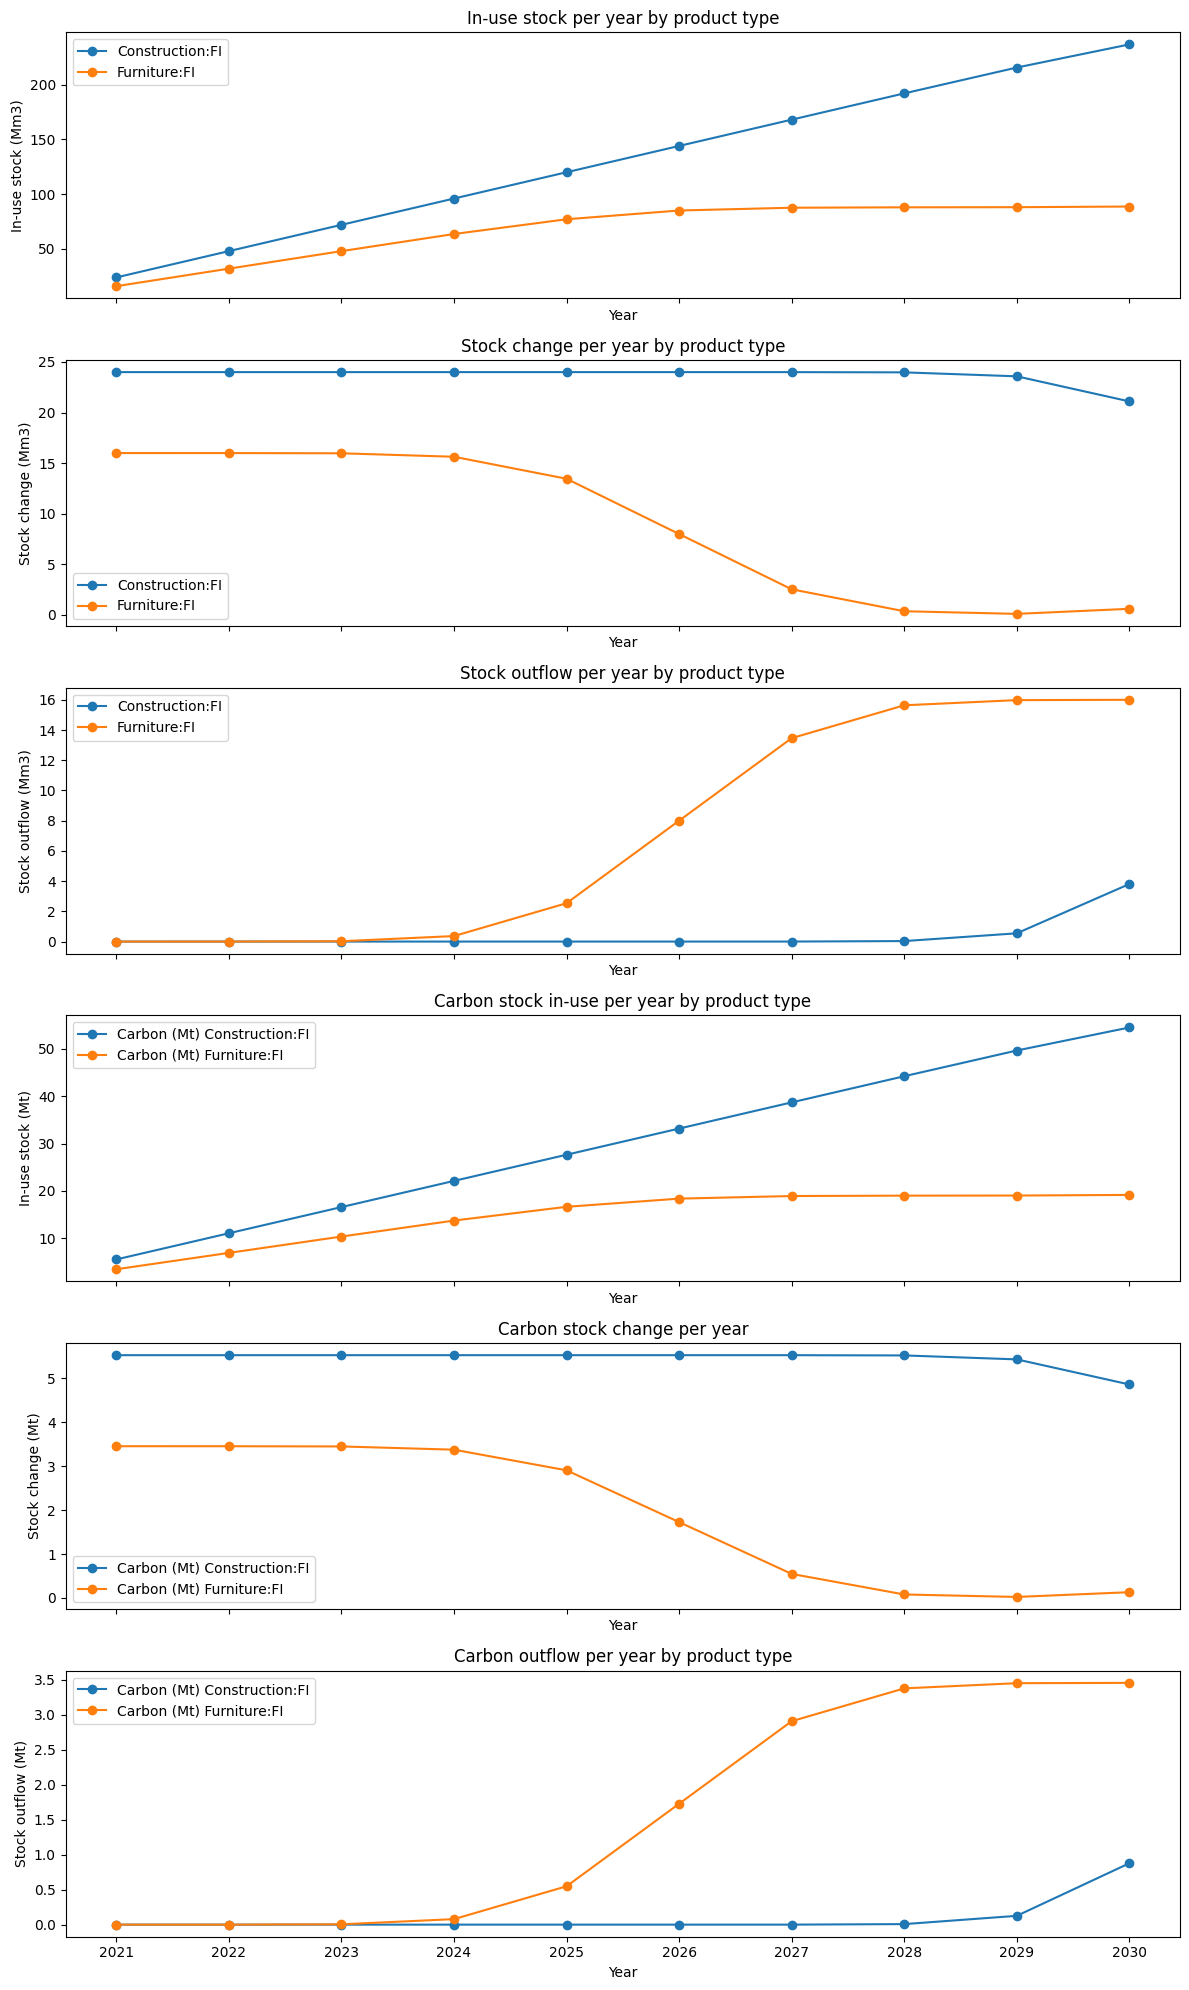

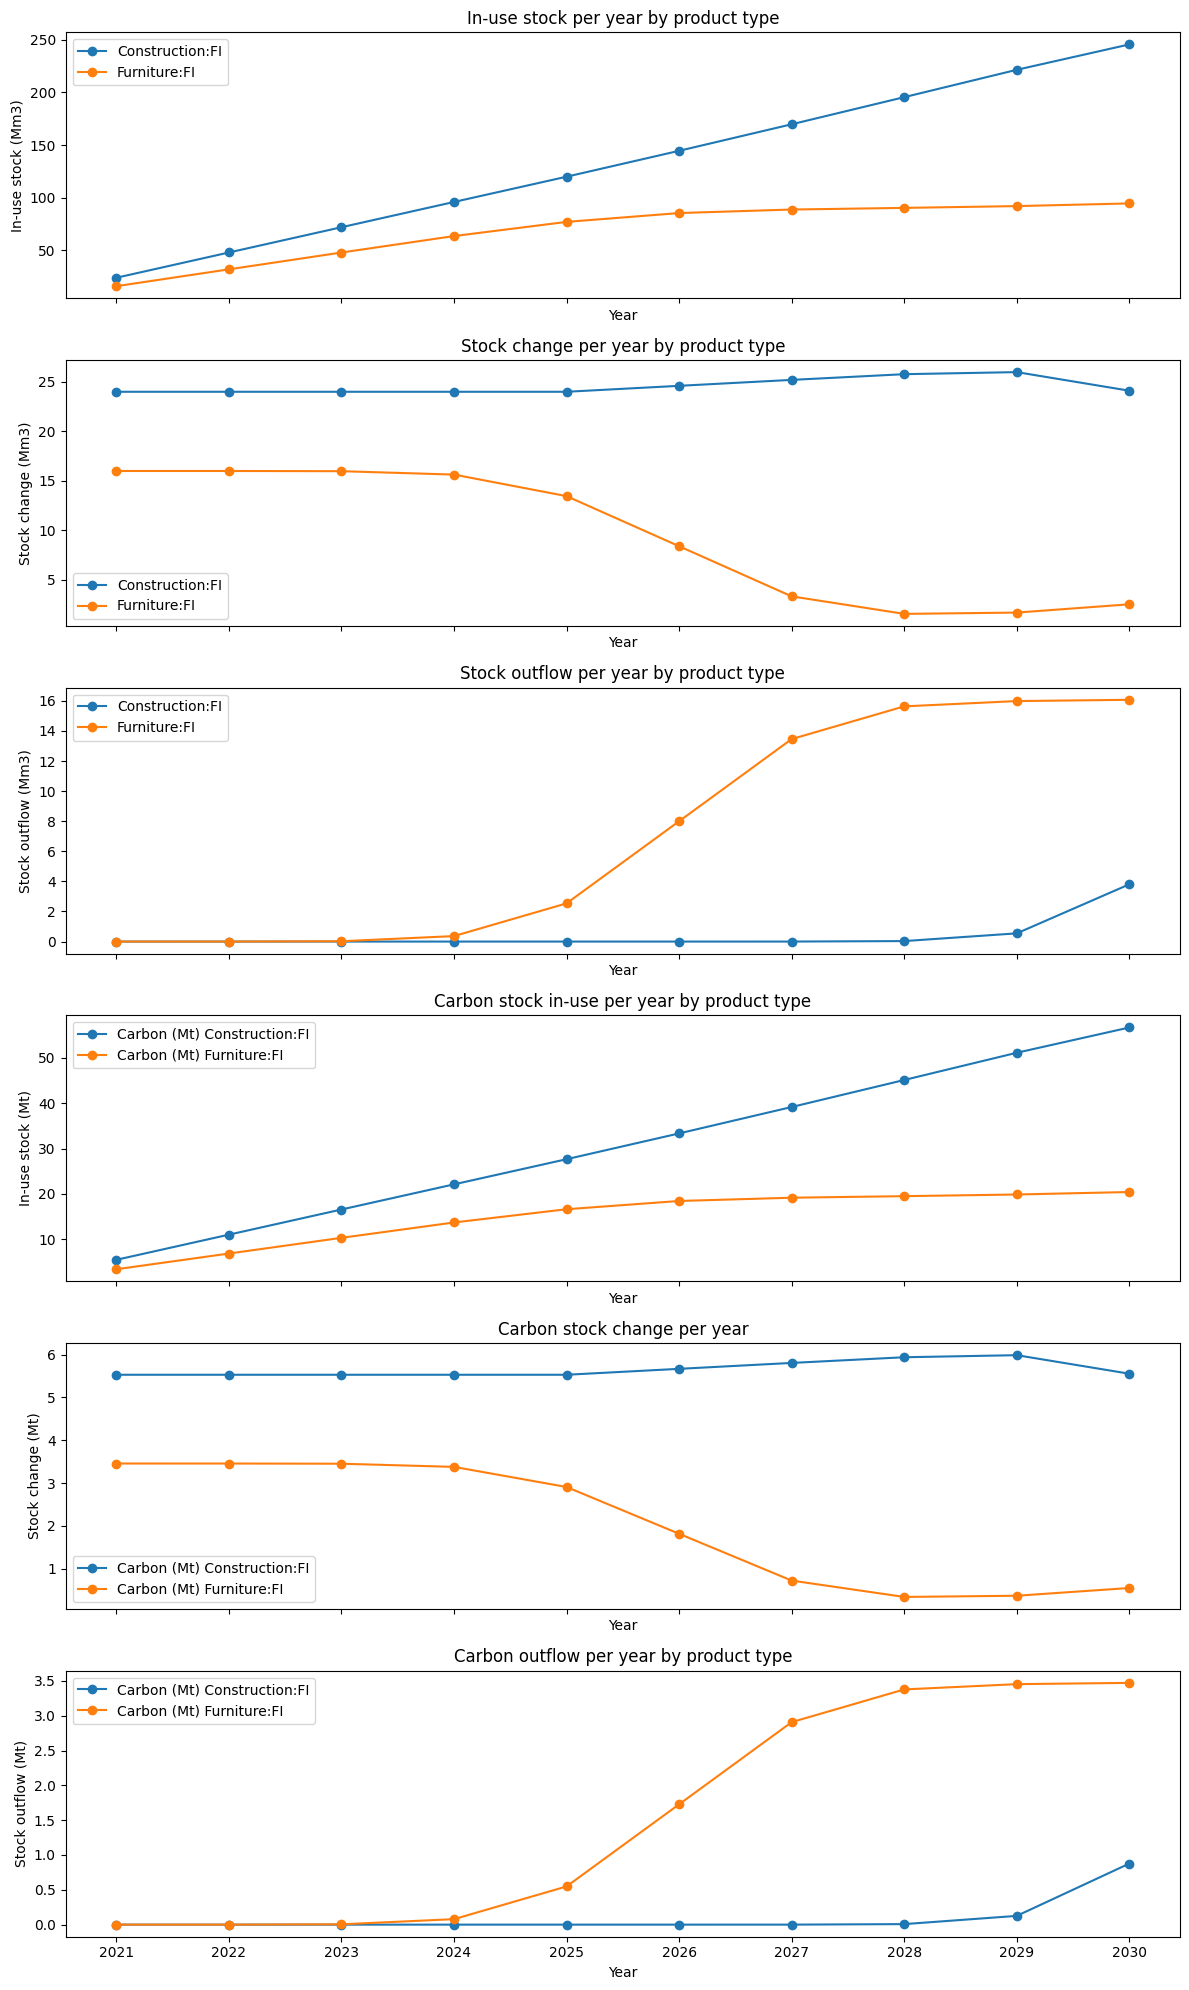

In [8]:
print("Build dynamic stock results...")
for scenario in scenarios:
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    scenario_output_path = scenario_name_to_output_path[scenario.name]

    # Full name of the baseline, e.g. "Solid wood equivalent"
    baseline_value_name = scenario.scenario_data.baseline_value_name
    baseline_unit_name = scenario.scenario_data.baseline_unit_name

    # Total number of indicators
    indicators = flow_solver.get_indicator_name_to_indicator()
    num_indicators = len(indicators.keys())

    # Baseline DSM
    stock_id_to_baseline_dsm = flow_solver.get_baseline_dynamic_stocks()
    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()

    if not len(stock_id_to_baseline_dsm.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    # Each baseline/indicator needs 3 plots
    # so total = baseline (3) + (number of indicators * 3)
    num_subplots = 3 + (num_indicators * 3)
    fig, axes = plt.subplots(num_subplots, 1, sharex='all', sharey='none', figsize=(12, 20))

    # Create an Excel writer for exporting data
    excel_filename = os.path.join(scenario_output_path, f"{scenario.name}_dynamic_stocks.xlsx")
    with pd.ExcelWriter(excel_filename) as writer:
        for stock_id, baseline_dsm in stock_id_to_baseline_dsm.items():
            plot_index = 0

            # Truncate the stock ID to 20 characters (or any suitable length) to fit within the 31 character limit
            stock_id_for_filename = stock_id[:20]  # Truncate to the first 20 characters
            stock_id_for_filename = stock_id_for_filename.replace(":", "_")  # Replace ":" with "_"

            # ******************
            # * Baseline stock *
            # ******************
            baseline_stock_by_cohort = baseline_dsm.compute_s_c_inflow_driven()
            baseline_outflow_by_cohort = baseline_dsm.compute_o_c_from_s_c()
            baseline_stock_total = baseline_dsm.compute_stock_total()
            baseline_stock_change = baseline_dsm.compute_stock_change()
            baseline_stock_outflow = baseline_dsm.compute_outflow_total()

            # Export stock by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_s_by_c_{baseline_value_name}')
            df_baseline_stock_by_cohort = pd.DataFrame(baseline_stock_by_cohort, columns=years, index=years)
            df_baseline_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export outflow by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{baseline_value_name}')
            df_baseline_outflow_by_cohort = pd.DataFrame(baseline_outflow_by_cohort, columns=years, index=years)
            df_baseline_outflow_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export stock total
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_stock_total_{baseline_value_name}')
            df_baseline_stock_total = pd.DataFrame(baseline_stock_total, index=years)
            df_baseline_stock_total.reset_index(inplace=True)
            df_baseline_stock_total.columns = ["Year", "Stock total ({})".format(baseline_unit_name)]
            df_baseline_stock_total.to_excel(writer, sheet_name=sheet_name)

            # Export stock change
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_s_change_{baseline_value_name}')
            df_baseline_stock_change = pd.DataFrame(baseline_stock_change, index=years)
            df_baseline_stock_change.reset_index(inplace=True)
            df_baseline_stock_change.columns = ["Year", "Stock change ({})".format(baseline_unit_name)]
            df_baseline_stock_change.to_excel(writer, sheet_name=sheet_name)

            # Export stock outflow total
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_s_o_total_{baseline_value_name}')
            df_baseline_stock_outflow = pd.DataFrame(baseline_stock_outflow, index=years)
            df_baseline_stock_outflow.reset_index(inplace=True)
            df_baseline_stock_outflow.columns = ["Year", "Stock outflow total ({})".format(baseline_unit_name)]
            df_baseline_stock_outflow.to_excel(writer, sheet_name=sheet_name)

            # Plot baseline stock total (in-use stocks)
            axes[plot_index + 0].plot(years, baseline_stock_total, marker='o', label="{}".format(stock_id))
            axes[plot_index + 0].set_ylabel("In-use stock ({})".format(baseline_unit_name))
            axes[plot_index + 0].set_title("In-use stock per year by product type")

            # Plot baseline stock change
            axes[plot_index + 1].plot(years, baseline_stock_change, marker='o', label=f'{stock_id}')
            axes[plot_index + 1].set_ylabel("Stock change ({})".format(baseline_unit_name))
            axes[plot_index + 1].set_title("Stock change per year by product type")

            # Plot baseline outflow by cohort
            axes[plot_index + 2].plot(years, baseline_stock_outflow, marker='o', label=f'{stock_id}')
            axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(baseline_unit_name))
            axes[plot_index + 2].set_title("Stock outflow per year by product type")

            plot_index += 3
            for indicator_name, indicator_dsm in stock_id_to_indicator_name_to_dsm[stock_id].items():
                # **************
                # * Indicators *
                # **************
                indicator_unit = indicators[indicator_name].unit

                indicator_stock_by_cohort = indicator_dsm.compute_s_c_inflow_driven()
                indicator_outflow_by_cohort = indicator_dsm.compute_o_c_from_s_c()
                indicator_stock_total = indicator_dsm.compute_stock_total()
                indicator_stock_change = indicator_dsm.compute_stock_change()
                indicator_stock_outflow = indicator_dsm.compute_outflow_total()

                # Export indicator stock by cohort
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_s_by_c_{indicator_name}")
                df_indicator_stock_by_cohort = pd.DataFrame(indicator_stock_by_cohort, columns=years, index=years)
                df_indicator_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

                # Export indicator outflow by cohort
                sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{indicator_name}')
                df_indicator_oc = pd.DataFrame(indicator_outflow_by_cohort, columns=years, index=years)
                df_indicator_oc.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock total
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_s_total_base_{indicator_name}")
                df_indicator_stock_total = pd.DataFrame(indicator_stock_total, index=years)
                df_indicator_stock_total.reset_index(inplace=True)
                df_indicator_stock_total.columns = ["Year", "Stock total ({})".format(indicator_name)]
                df_indicator_stock_total.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock change
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_stock_change_{indicator_name}")
                df_indicator_stock_change = pd.DataFrame(indicator_stock_change, index=years)
                df_indicator_stock_change.reset_index(inplace=True)
                df_indicator_stock_change.columns = ["Year", "Stock change ({})".format(indicator_name)]
                df_indicator_stock_change.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock outflow total
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_s_o_total_{indicator_name}")
                df_indicator_stock_outflow = pd.DataFrame(indicator_stock_outflow, index=years)
                df_indicator_stock_outflow.reset_index(inplace=True)
                df_indicator_stock_outflow.columns = ["Year", "Stock outflow total ({})".format(indicator_name)]
                df_indicator_stock_outflow.to_excel(writer, sheet_name=sheet_name)

                # Plot indicator stock total (in-use stocks)
                axes[plot_index + 0].plot(years, indicator_stock_total, marker='o', label='{} ({}) {}'.format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 0].set_ylabel("In-use stock ({})".format(indicator_unit))
                axes[plot_index + 0].set_title("{} stock in-use per year by product type".format(indicator_name))

                # Plot indicator stock change
                axes[plot_index + 1].plot(years, indicator_stock_change, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 1].set_ylabel("Stock change ({})".format(indicator_unit))
                axes[plot_index + 1].set_title("{} stock change per year".format(indicator_name))

                # Plot indicator outflow by cohort
                axes[plot_index + 2].plot(years, indicator_stock_outflow, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id
                ))
                axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(indicator_unit))
                axes[plot_index + 2].set_title("{} outflow per year by product type".format(indicator_name))

                plot_index += 3

        # Set common properties to axes
        range_x_ticks = range(min(years), max(years) + 1)
        for axis in axes:
            axis.set_xlabel("Year")
            axis.title.set_size(12)
            axis.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path, "{}_stock_plots_by_product.svg".format(scenario.name))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()


Calculating annual CO2 stock removals results...
Exporting annual CO2 removal (Mt) by stock results...
Exporting annual CO2 removal (Mt) by stock results...


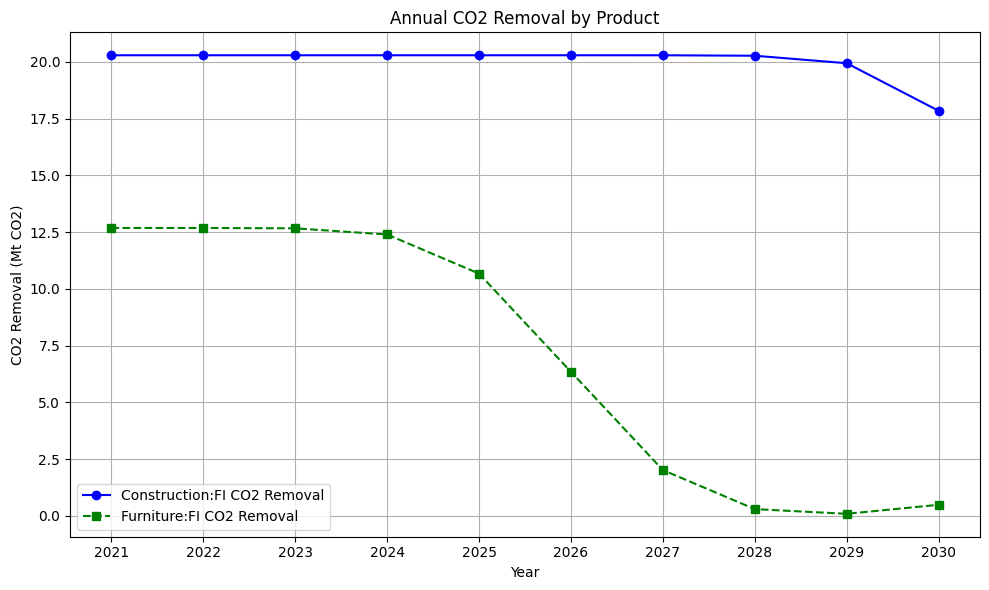

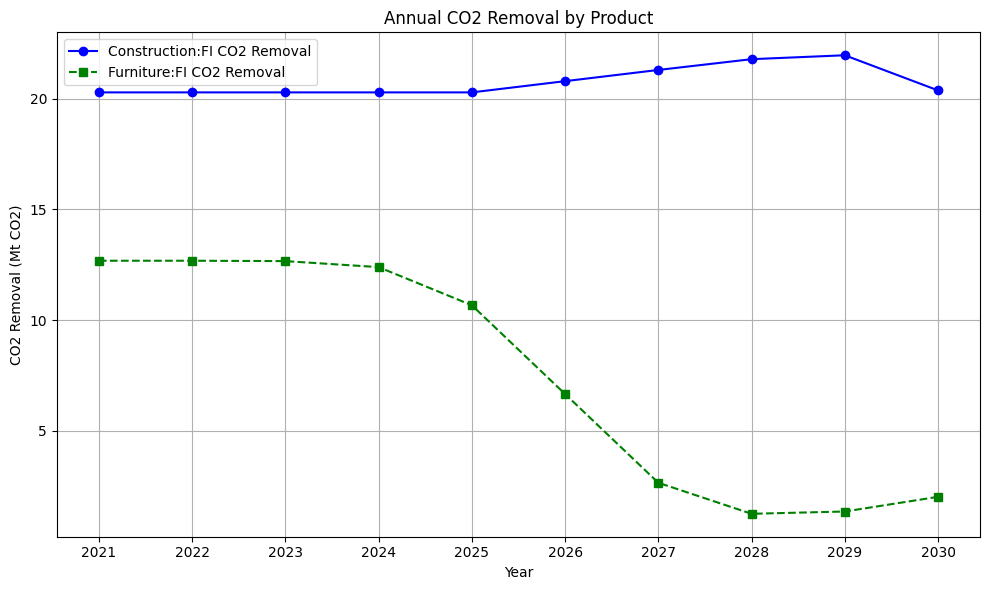

In [9]:
# *****************************************************
# * Step 6: Convert the carbon stocks to CO2 removals *
# *****************************************************
print("Calculating annual CO2 stock removals results...")
for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    year_start = scenario.scenario_data.start_year

    # Calculate CO2 removals for each stock and plot the results
    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()
    if not len(stock_id_to_indicator_name_to_dsm.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    results_co2_removals = pd.DataFrame({'Year': years})
    conversion_factor_c_to_co2 = model_params[ParameterName.ConversionFactorCToCO2]

    # Define line styles, markers, and colors for differentiation
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    target_indicator_name = "Carbon"
    plt.figure(figsize=(10, 6))
    for index, (stock_id, indicator_name_to_dsm) in enumerate(stock_id_to_indicator_name_to_dsm.items()):
        if target_indicator_name not in indicator_name_to_dsm:
            continue

        # Get stock inflows and outflows for target indicator
        dsm = indicator_name_to_dsm[target_indicator_name]
        total_inflows_carbon = dsm.i
        total_outflows_carbon = dsm.o
        annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * conversion_factor_c_to_co2
        results_co2_removals[stock_id] = annual_co2_removal

        line_style = line_styles[index % len(line_styles)]
        marker = markers[index % len(markers)]
        color = colors[index % len(colors)]
        plt.plot(years, results_co2_removals[stock_id], marker=marker, linestyle=line_style, color=color,
                 label=f'{stock_id} CO2 Removal')

    plt.xlabel('Year')
    plt.ylabel('CO2 Removal (Mt CO2)')
    plt.title('Annual CO2 Removal by Product')
    plt.grid(True)
    tick_gap = 1 if len(years) < 15 else 10
    plt.xticks(years[::tick_gap])
    plt.legend()
    plt.tight_layout()

    # Export CO2 removal data to CSV
    print("Exporting annual CO2 removal (Mt) by stock results...")
    filename = os.path.join(scenario_output_path, "{}_annual_co2_removal_by_stock.csv".format(scenario.name))
    results_co2_removals.to_csv(path_or_buf=filename, index=False, mode="w")

    # Export CO2 removal plot as SVG
    filename = os.path.join(scenario_output_path, "{}_annual_co2_removal_by_product.svg".format(scenario.name))
    plt.savefig(filename, format='svg')

    if model_params[ParameterName.ShowPlots]:
        plt.show()

In [10]:
# ************************************************************
# * Step 7: Visualize inflows per year to selected processes *
# ************************************************************

# This is only done only when there is multiple years
# Visualize inflows per year to processes
visualize_inflows_to_process_ids = model_params[ParameterName.VisualizeInflowsToProcesses]
for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years

    # Dictionary: Process ID to process
    unique_processes = flow_solver.get_unique_processes()
    for process_id in visualize_inflows_to_process_ids:
        process = flow_solver.get_process(process_id, min(years))
        flow_id_to_source_process_id = {}
        source_process_names = []

        # Find all source processes of all incoming flows to this process in all years
        # This is needed to create stable set of process names so that the relative
        # position of the processes stay the same in stacked chart between the years
        source_process_ids = set()
        for year in years:
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            unique_flow_ids = set()
            for flow in inflows:
                unique_flow_ids.add(flow.id)
                flow_id_to_source_process_id[flow.id] = flow.source_process_id

            # Find source process ID of each incoming flow and add
            # to list of unique source process IDs if not already there
            unique_flow_ids = list(unique_flow_ids)
            for flow_id in unique_flow_ids:
                source_process_ids.add(flow_id_to_source_process_id[flow_id])

        # Now source_process_ids-list contains list of all the possible process IDs
        # that have flows incoming to process_id. This list is needed to keep the
        # incoming process IDs the same every year because aiphoria allows the connections
        # between the flows to change between the years.
        source_process_ids = list(source_process_ids)

        # Create 2D array with shape of (number of source process IDs, number of years)
        # and fill with the value of the inflow from source process for each year
        df_inflows_to_process = pd.DataFrame(columns=['Year', 'Source Process ID', 'Value ({})'.format(
            model_params[ParameterName.BaselineUnitName])])
        source_process_by_flow_values = np.ndarray(shape=(len(source_process_ids), len(years)))
        for year_index, year in enumerate(years):
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            for flow in inflows:
                source_process_id_index = source_process_ids.index(flow.source_process_id)
                source_process_by_flow_values[source_process_id_index, year_index] = flow.evaluated_value
                df_inflows_to_process.loc[len(df_inflows_to_process)] = [year, flow.source_process_id,
                                                                         flow.evaluated_value]
        df_inflows_to_process = df_inflows_to_process.round(5)

        # Export inflows to process to CSV file
        # NOTE: Replace character ':' in Process ID to underscore because Windows system are not able to handle that character in filename
        process_id_for_filename = process_id.replace(":", "_")
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.csv".format(scenario.name, process_id_for_filename))
        df_inflows_to_process.to_csv(path_or_buf=filename, index=False, mode="w")

        # Initialize the figure and axes for the stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.stackplot(years, source_process_by_flow_values, labels=list(source_process_ids))
        ax.set_ylabel("Mm3 SWE")
        ax.set_title("Inputs to {}".format(process.name))
        ax.legend(loc='upper left')
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.svg".format(scenario.name, process_id_for_filename))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()


In [11]:
# *****************************************************
# * Step 8: Visualize the flow graph as Sankey graph *
# *****************************************************

# Create color name to color value mapping
transformation_stage_name_to_color = {color.name: color.value for color in dataprovider.get_color_definitions()}

# Virtual process graph label overrides
# TODO: Move also this to settings file?
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    # TODO: Move this to settings file?
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": transformation_stage_name_to_color,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",
    #"virtual_process_color": "#707070",

    # Color for virtual flows
    "virtual_flow_color": "#808080",
}

# NOTE: Now each scenario is in it's own graph
if model_params[ParameterName.CreateSankeyCharts]:
    visualizer = DataVisualizer()
    visualizer.build_and_show(scenarios, visualizer_params, model_params)
